# FAKE AND TRUE NEWS

<p> We have to build an algorithm which is able to determine if an article is fake news or not?

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import re
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, LSTM, Embedding, Flatten, BatchNormalization, Dropout, Dense
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import random as rn

# 1. Loading Data

In [4]:
#loading fake data
fake_data=pd.read_csv('Fake.csv')
print("Number of data points", fake_data.shape)
print('='*50)
print("Columns of train data :", fake_data.columns.values)
print("="*50)

Number of data points (23481, 4)
Columns of train data : ['title' 'text' 'subject' 'date']


In [5]:
la=[]
for i in range(fake_data.shape[0]):
    la.append(0)
print(len(la))

23481


In [6]:
# label=0 for fake news

la=pd.DataFrame(la)
la.columns=['label']
df_fake=pd.concat([fake_data,la],axis=1)
print("shape of fake data after labelling:",df_fake.shape)
print("="*100)
df_fake.head()

shape of fake data after labelling: (23481, 5)


,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [7]:
#loading true data

true_data=pd.read_csv('True.csv')
print("Number of data points", true_data.shape)
print('='*50)
print("Columns of train data :", true_data.columns.values)
print("="*50)
true_data.head(2)

Number of data points (21417, 4)
Columns of train data : ['title' 'text' 'subject' 'date']


,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"


In [8]:
lb=[]
for i in range(true_data.shape[0]):
    lb.append(1)
print(len(lb))

21417


In [9]:
# label=0 for true news

lb=pd.DataFrame(lb)
lb.columns=['label']
df_true=pd.concat([true_data,lb],axis=1)
print("shape of true data after labelling:",df_true.shape)
print("="*100)
df_true.head()

shape of true data after labelling: (21417, 5)


,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


## 1.1 Concatenating both Fake and True news to a single data frame

In [10]:
final_data=pd.concat([df_true,df_fake],axis=0)
print(final_data.shape)

(44898, 5)


In [11]:
final_data.head(4)

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1


## 1.2 Finding Null value in dataset and replace it with "nan"

In [12]:
# finding null value in my dataset
final_data.isnull().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

__No value is missing in my data.__

## 1.3 Finding duplicate data and remove them

In [13]:
print("Numbr of data point where text data are duplicates:",final_data['text'].duplicated().sum())

Numbr of data point where text data are duplicates: 6252


In [14]:
print("shape before removing duplicate data:",final_data.shape)
print("="*50)
final_data.drop_duplicates(subset=['text'],keep='first',inplace=True) #removing duplicate data on the basis of text columns only
print("shape of data after removing duplicate number:",final_data.shape)
print("="*50)

shape before removing duplicate data: (44898, 5)
shape of data after removing duplicate number: (38646, 5)


# 2. EDA

### Text

In [0]:
true_count=final_data[final_data['label']==1]['text'].str.split().apply(len)#counting number of word in each sentence where the label is 1
true_count=true_count.values
false_count=final_data[final_data['label']==0]['text'].str.split().apply(len)#counting number of word in each sentence where the label is 0
false_count=false_count.values

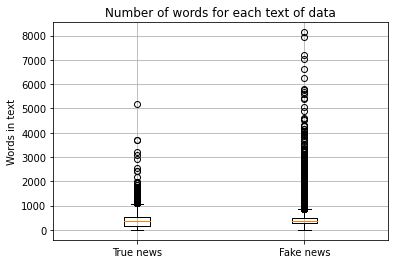

In [16]:
plt.boxplot([true_count,false_count])
plt.title('Number of words for each text of data')
plt.xticks([1,2],("True news", "Fake news"))
plt.ylabel("Words in text")
plt.grid()
plt.show()

__This boxplot shows that the number of words in text data of true news is smaller then the number of word in text data of fake news.__

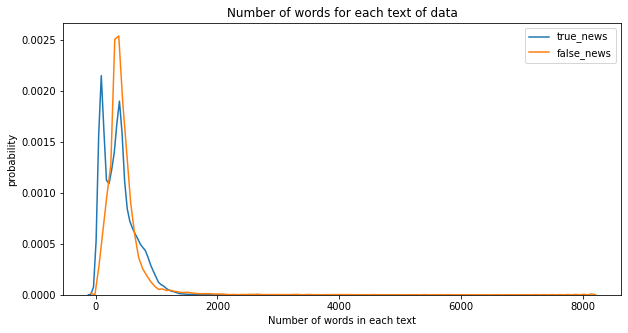

In [17]:
plt.figure(figsize=(10,5))
sns.distplot(true_count, hist=False, label="true_news")
sns.distplot(false_count, hist=False, label="false_news")
plt.title('Number of words for each text of data')
plt.xlabel('Number of words in each text')
plt.ylabel('probability')
plt.legend()
plt.show()

__If the number of words in text data is high then the probability of the news article to be fake is large.__

### Title

In [0]:
true_count=final_data[final_data['label']==1]['title'].str.split().apply(len)#counting number of word in each sentence where the label is 1
true_count=true_count.values
false_count=final_data[final_data['label']==0]['title'].str.split().apply(len)#counting number of word in each sentence where the label is 0
false_count=false_count.values

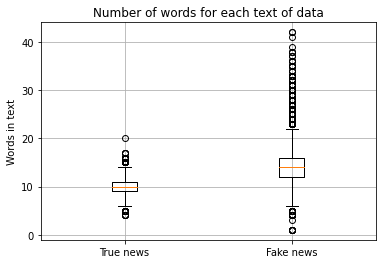

In [19]:
plt.boxplot([true_count,false_count])
plt.title('Number of words for each text of data')
plt.xticks([1,2],("True news", "Fake news"))
plt.ylabel("Words in text")
plt.grid()
plt.show()

__This boxplot shows that the number of words in title data of true news is smaller then the number of word in title data of fake news.__

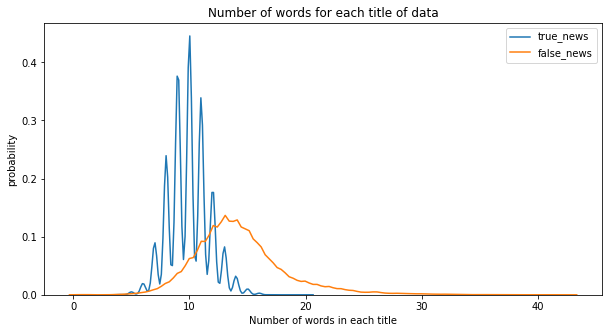

In [20]:
plt.figure(figsize=(10,5))
sns.distplot(true_count, hist=False, label="true_news")
sns.distplot(false_count, hist=False, label="false_news")
plt.title('Number of words for each title of data')
plt.xlabel('Number of words in each title')
plt.ylabel('probability')
plt.legend()
plt.show()

__If the number of word in title data is approximately less than 15 then the probability of news to be true is high and if the number of word is greater than 10 in title data then the probability of news to be fake is high.__

### Subject

In [21]:
print(final_data['subject'].describe())
print("="*50)
print(final_data['subject'].value_counts())

count            38646
unique               7
top       politicsNews
freq             11214
Name: subject, dtype: object
politicsNews       11214
worldnews           9978
News                9050
politics            6424
US_News              783
left-news            683
Government News      514
Name: subject, dtype: int64


__There are 7 unique type of news article we have, in which frequency of politicsnews is large then the other news.__

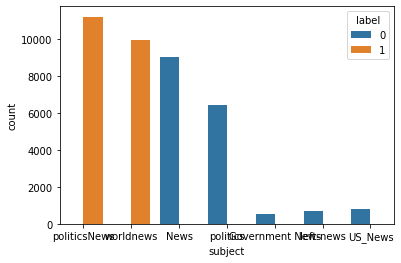

In [22]:
sns.countplot(x=final_data['subject'],hue=final_data['label'])

__1. If the news is politics news and world news then the probabilty of the news to be true is high.__

__2. Frequency of politics news and world news is also greater then the other news.__

### Date

In [23]:
print(final_data['date'].describe())
print("="*50)

count                 38646
unique                 2397
top       December 6, 2017 
freq                    166
Name: date, dtype: object


In [24]:
print(final_data['date'].value_counts())

December 6, 2017                                                                                                                                     166
November 30, 2017                                                                                                                                    160
November 9, 2017                                                                                                                                     157
October 13, 2017                                                                                                                                     153
September 21, 2017                                                                                                                                   153
                                                                                                                                                    ... 
https://100percentfedup.com/served-roy-moore-vietnamletter-veteran-sets-record-str

### No any data is missing in my date columns. But some of data point in date column contain url.

# 3. Data preprocessing

## 3.1 Date

In [0]:
months=['january','february','march','april','may','june','july','august','september','october','november','december']

In [0]:
def decontract_months(phrase):
    # specific
    #phrase = phrase.lower()
    phrase = re.sub(r"jan", "january", phrase)
    phrase = re.sub(r"feb", "february", phrase)
    phrase = re.sub(r"mar", "march", phrase)
    phrase = re.sub(r"apr", "april", phrase)
    phrase = re.sub(r"jun", "june", phrase)
    phrase = re.sub(r"jul", "july", phrase)
    phrase = re.sub(r"aug", "august", phrase)
    phrase = re.sub(r"sep", "september", phrase)
    phrase = re.sub(r"oct", "october", phrase)
    phrase = re.sub(r"nov", "november", phrase)
    phrase = re.sub(r"dec", 'december',phrase)
    return phrase

In [27]:
preprocessed_date=[]
from tqdm import tqdm
for sent in tqdm(final_data['date'].values):
    
    sent=sent.lower()
    if sent.split()[0] not in months:
        sent=decontract_months(sent)#replacing jan with january and similary all those which are retain in short form
    
    sent=re.sub("https\S+","nan",sent) #replacing https with "nan"
    
    sent=sent.replace(',','')
    
    sent='_'.join(e for e in sent.split())
    preprocessed_date.append(sent)
    
final_data['date']=preprocessed_date

100%|██████████| 38646/38646 [00:00<00:00, 216059.57it/s]


In [28]:
print(final_data['date'].value_counts()[:5])

december_6_2017      177
november_30_2017     172
november_9_2017      171
september_21_2017    167
october_13_2017      165
Name: date, dtype: int64


In [29]:
final_data[final_data['date']=='nan']

,title,text,subject,date,label
9358,https://100percentfedup.com/served-roy-moore-v...,https://100percentfedup.com/served-roy-moore-v...,politics,nan,0
15507,https://100percentfedup.com/video-hillary-aske...,https://100percentfedup.com/video-hillary-aske...,politics,nan,0
15508,https://100percentfedup.com/12-yr-old-black-co...,https://100percentfedup.com/12-yr-old-black-co...,politics,nan,0
15839,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,nan,0
15840,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,nan,0


### Date columns in which we replace https to "nan", it's corresponding title and text also contain https so we remove the data point in which date value is 'nan'.

In [30]:
print("shape of the data point before droping the 'https':",final_data.shape)
print("="*50)
final_data.drop(final_data[final_data['date']=='nan'].index,inplace=True)
print("shape of the data point after droping the 'https':",final_data.shape)
print("="*50)

shape of the data point before droping the 'https': (38646, 5)
shape of the data point after droping the 'https': (38636, 5)


In [31]:
print(final_data['date'].describe())

count               38636
unique               1011
top       december_6_2017
freq                  177
Name: date, dtype: object


### After doing all the preprocessing step the number of unique value in date column is decreases.

## 3.2 Data preprocessing of Text and Title data

In [32]:
final_data['text'].values[7]

'The following statements\xa0were posted to the verified Twitter accounts of U.S. President Donald Trump, @realDonaldTrump and @POTUS.  The opinions expressed are his own.\xa0Reuters has not edited the statements or confirmed their accuracy.  @realDonaldTrump : - While the Fake News loves to talk about my so-called low approval rating, @foxandfriends just showed that my rating on Dec. 28, 2017, was approximately the same as President Obama on Dec. 28, 2009, which was 47%...and this despite massive negative Trump coverage & Russia hoax! [0746 EST] - Why is the United States Post Office, which is losing many billions of dollars a year, while charging Amazon and others so little to deliver their packages, making Amazon richer and the Post Office dumber and poorer? Should be charging MUCH MORE! [0804 EST] -- Source link: (bit.ly/2jBh4LU) (bit.ly/2jpEXYR) '

In [33]:
sent = re.sub('@\S+', ' ', final_data['text'].values[7]) #Removing all the twitter accounts like @realDonaldTrump
sent

'The following statements\xa0were posted to the verified Twitter accounts of U.S. President Donald Trump,   and    The opinions expressed are his own.\xa0Reuters has not edited the statements or confirmed their accuracy.    : - While the Fake News loves to talk about my so-called low approval rating,   just showed that my rating on Dec. 28, 2017, was approximately the same as President Obama on Dec. 28, 2009, which was 47%...and this despite massive negative Trump coverage & Russia hoax! [0746 EST] - Why is the United States Post Office, which is losing many billions of dollars a year, while charging Amazon and others so little to deliver their packages, making Amazon richer and the Post Office dumber and poorer? Should be charging MUCH MORE! [0804 EST] -- Source link: (bit.ly/2jBh4LU) (bit.ly/2jpEXYR) '

In [34]:
sent = re.sub('bit\S+', ' ', sent) #Removing all the links like bit.ly/2jBh4LU
sent

'The following statements\xa0were posted to the verified Twitter accounts of U.S. President Donald Trump,   and    The opinions expressed are his own.\xa0Reuters has not edited the statements or confirmed their accuracy.    : - While the Fake News loves to talk about my so-called low approval rating,   just showed that my rating on Dec. 28, 2017, was approximately the same as President Obama on Dec. 28, 2009, which was 47%...and this despite massive negative Trump coverage & Russia hoax! [0746 EST] - Why is the United States Post Office, which is losing many billions of dollars a year, while charging Amazon and others so little to deliver their packages, making Amazon richer and the Post Office dumber and poorer? Should be charging MUCH MORE! [0804 EST] -- Source link: (  (  '

In [35]:
sent=re.sub('[^A-Za-z0-9]', ' ', sent) #removing all the punctuation marks  
sent

'The following statements were posted to the verified Twitter accounts of U S  President Donald Trump    and    The opinions expressed are his own  Reuters has not edited the statements or confirmed their accuracy         While the Fake News loves to talk about my so called low approval rating    just showed that my rating on Dec  28  2017  was approximately the same as President Obama on Dec  28  2009  which was 47    and this despite massive negative Trump coverage   Russia hoax   0746 EST    Why is the United States Post Office  which is losing many billions of dollars a year  while charging Amazon and others so little to deliver their packages  making Amazon richer and the Post Office dumber and poorer  Should be charging MUCH MORE   0804 EST     Source link        '

In [0]:
#https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [0]:
from tqdm import tqdm

#combining all the steps we had done earlier
def preprocess_fun(preprocess):
    preprocessed_text = []

    for sentance in tqdm(preprocess):
        sent = decontracted(sentance)
        
        sent = re.sub('@\S+', ' ', sent)
        
        sent = re.sub('bit\S+', ' ', sent)
        
        sent=re.sub('https\S+',' ',sent)
        
        sent=re.sub('[^A-Za-z0-9]', ' ', sent)
        
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_text.append(sent)
        
    return preprocessed_text

## Text data

In [39]:
pre_text_data=preprocess_fun(final_data['text'])
final_data['text']=pre_text_data
final_data.head(2)

100%|██████████| 38636/38636 [00:35<00:00, 1098.25it/s]


,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON Reuters head conservative Republica...,politicsNews,december_31_2017,1
1,U.S. military to accept transgender recruits o...,WASHINGTON Reuters Transgender people allowed ...,politicsNews,december_29_2017,1


## Title Data

In [40]:
pre_title_data=preprocess_fun(final_data['title'])
final_data['title']=pre_title_data
final_data.head(2)

100%|██████████| 38636/38636 [00:01<00:00, 23267.61it/s]


,title,text,subject,date,label
0,U budget fight looms Republicans flip fiscal s...,WASHINGTON Reuters head conservative Republica...,politicsNews,december_31_2017,1
1,U military accept transgender recruits Monday ...,WASHINGTON Reuters Transgender people allowed ...,politicsNews,december_29_2017,1


<h2>4. Splitting data into Train and cross validation and Test data</h2>

In [41]:
y = final_data['label'].values
x = final_data.drop(['label'], axis=1)
x.head(5)

,title,text,subject,date
0,U budget fight looms Republicans flip fiscal s...,WASHINGTON Reuters head conservative Republica...,politicsNews,december_31_2017
1,U military accept transgender recruits Monday ...,WASHINGTON Reuters Transgender people allowed ...,politicsNews,december_29_2017
2,Senior U Republican senator Let Mr Mueller job,WASHINGTON Reuters special counsel investigati...,politicsNews,december_31_2017
3,FBI Russia probe helped Australian diplomat ti...,WASHINGTON Reuters Trump campaign adviser Geor...,politicsNews,december_30_2017
4,Trump wants Postal Service charge amuch Amazon...,SEATTLE WASHINGTON Reuters President Donald Tr...,politicsNews,december_29_2017


In [0]:
# train test split
from sklearn.model_selection import train_test_split
x_1, x_test, y_1, y_test = train_test_split(x, y, test_size=0.2, stratify=y)
x_train, x_cv, y_train, y_cv = train_test_split(x_1, y_1, test_size=0.2, stratify=y_1)

In [43]:
print("shape of x_train and y_train",x_train.shape,y_train.shape)
print("shape of x_train and y_train",x_train.shape,y_train.shape)
print("shape of x_train and y_train",x_train.shape,y_train.shape)
print("="*100)

shape of x_train and y_train (24726, 4) (24726,)
shape of x_train and y_train (24726, 4) (24726,)
shape of x_train and y_train (24726, 4) (24726,)


<h2>5. One hot encoding of categorical feature: subject and date</h2>

### 5.1 Subject_data

In [44]:
subject_vec = CountVectorizer()
subject_vec.fit(x_train['subject'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
x_train_subject = subject_vec.transform(x_train['subject'].values).toarray()
x_cv_subject = subject_vec.transform(x_cv['subject'].values).toarray()
x_test_subject = subject_vec.transform(x_test['subject'].values).toarray()

print("After vectorizations")
print(x_train_subject.shape, y_train.shape)
print(x_cv_subject.shape, y_cv.shape)
print(x_test_subject.shape, y_test.shape)
print(subject_vec.get_feature_names())
print("="*100)

After vectorizations
(24726, 7) (24726,)
(6182, 7) (6182,)
(7728, 7) (7728,)
['government', 'left', 'news', 'politics', 'politicsnews', 'us_news', 'worldnews']


In [0]:
import pickle
with open('count_subject.pickle','wb') as f:#saving the vectorizer
    pickle.dump(subject_vec,f)

### 5.2 Date

In [47]:
date_vec = CountVectorizer()
date_vec.fit(x_train['date'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
x_train_date = date_vec.transform(x_train['date'].values).toarray()
x_cv_date = date_vec.transform(x_cv['date'].values).toarray()
x_test_date = date_vec.transform(x_test['date'].values).toarray()

print("After vectorizations")
print(x_train_date.shape, y_train.shape)
print(x_cv_date.shape, y_cv.shape)
print(x_test_date.shape, y_test.shape)
print("="*100)

After vectorizations
(24726, 1008) (24726,)
(6182, 1008) (6182,)
(7728, 1008) (7728,)


In [0]:
with open('count_date.pickle','wb') as f:#saving the vectorizer
    pickle.dump(date_vec,f)

<h2>6. Make Data Model Ready: encoding text, and title</h2>

## 6.1 Bag Of Word On Text and Title Data

### Text

In [49]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vec = CountVectorizer(min_df=10)
vec.fit(x_train['text'])
x_train_text_bow = vec.transform(x_train['text'])
x_cv_text_bow = vec.transform(x_cv['text'])
x_test_text_bow = vec.transform(x_test['text'])


print("Shape of text train data after one hot encodig ",x_train_text_bow.shape)
print("Shape of text cv data after one hot encodig ",x_cv_text_bow.shape)
print("Shape of text text data after one hot encodig ",x_test_text_bow.shape)

Shape of text train data after one hot encodig  (24726, 21539)
Shape of text cv data after one hot encodig  (6182, 21539)
Shape of text text data after one hot encodig  (7728, 21539)


In [0]:
with open('count_text.pickle','wb') as f:#saving the vectorizer
    pickle.dump(vec,f)

### Title

In [51]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vect = CountVectorizer(min_df=10)
vect.fit(x_train['title'])
x_train_title_bow = vect.transform(x_train['title'])
x_cv_title_bow = vect.transform(x_cv['title'])
x_test_title_bow = vect.transform(x_test['title'])


print("Shape of title train data after one hot encodig ",x_train_title_bow.shape)
print("Shape of title cv data after one hot encodig ",x_cv_title_bow.shape)
print("Shape of title text data after one hot encodig ",x_test_title_bow.shape)

Shape of title train data after one hot encodig  (24726, 3634)
Shape of title cv data after one hot encodig  (6182, 3634)
Shape of title text data after one hot encodig  (7728, 3634)


In [0]:
with open('count_title.pickle','wb') as f:#saving the vectorizer
    pickle.dump(vec,f)

## 6.2 TFIDF vectorizer on Text and Title

In [53]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
tfidf_text = TfidfVectorizer(min_df=10)
tfidf_text.fit(x_train['text'])
x_train_text_tfidf = tfidf_text.transform(x_train['text'])
x_cv_text_tfidf = tfidf_text.transform(x_cv['text'])
x_test_text_tfidf = tfidf_text.transform(x_test['text'])


print("Shape of text train data after one hot encodig ",x_train_text_tfidf.shape)
print("Shape of text cv data after one hot encodig ",x_cv_text_tfidf.shape)
print("Shape of text text data after one hot encodig ",x_test_text_tfidf.shape)

Shape of text train data after one hot encodig  (24726, 21539)
Shape of text cv data after one hot encodig  (6182, 21539)
Shape of text text data after one hot encodig  (7728, 21539)


In [0]:
with open('tfidf_text_vectorizer.pickle', 'wb') as f:#saving the text vectorizer
    pickle.dump(tfidf_text,f)

In [55]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
tfidf_title = CountVectorizer(min_df=10)
tfidf_title.fit(x_train['title'])
x_train_title_tfidf = tfidf_title.transform(x_train['title'])
x_cv_title_tfidf = tfidf_title.transform(x_cv['title'])
x_test_title_tfidf = tfidf_title.transform(x_test['title'])


print("Shape of title train data after one hot encodig ",x_train_title_tfidf.shape)
print("Shape of title cv data after one hot encodig ",x_cv_title_tfidf.shape)
print("Shape of title text data after one hot encodig ",x_test_title_tfidf.shape)

Shape of title train data after one hot encodig  (24726, 3634)
Shape of title cv data after one hot encodig  (6182, 3634)
Shape of title text data after one hot encodig  (7728, 3634)


In [0]:
with open('tfidf_title_vectorizer.pickle', 'wb') as f:#saving the title vectorizer
    pickle.dump(tfidf_title,f)

## 7. Adding New Feature : Number of topic explained by my data

### Topic Modelling

In [57]:
from sklearn.decomposition import LatentDirichletAllocation
#https://medium.com/@yanlinc/how-to-build-a-lda-topic-model-using-from-text-601cdcbfd3a6
    
n_component=[2,5,10,15,20,25]
log_train=[]

for i in tqdm(n_component):
    lda = LatentDirichletAllocation(n_components=i,n_jobs=-1)
    lda.fit(x_train_text_bow)
    
    log_train.append(lda.score(x_train_text_bow))

100%|██████████| 6/6 [35:40<00:00, 356.67s/it]


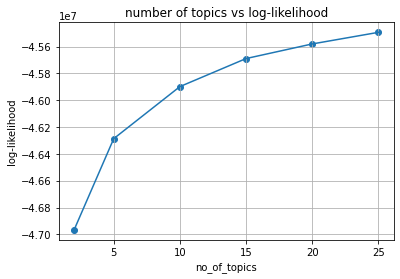

In [58]:
import matplotlib.pyplot as plt
plt.plot(n_component, log_train)
plt.scatter(n_component, log_train)
plt.xlabel('no_of_topics')
plt.ylabel('log-likelihood')
plt.title('number of topics vs log-likelihood')
plt.grid()
plt.show()

In [0]:
from sklearn.decomposition import LatentDirichletAllocation
#taking number of topics = 20
number_of_topics=20
lda_model = LatentDirichletAllocation(n_components=number_of_topics,n_jobs=-1)
lda_model.fit(x_train_text_bow)
lda_train=lda_model.transform(x_train_text_bow)
lda_cv=lda_model.transform(x_cv_text_bow)
lda_test=lda_model.transform(x_test_text_bow)

In [0]:
with open('lda.pickle','wb') as f:#saving the vectorizer
    pickle.dump(lda_model,f)

### Taking top 5 topics

In [0]:
#calculating number of document in which topic t is dominant
def function(data):
    dic=dict()
    for i in range(number_of_topics):#forming a dictionary of topic 1 to 20 and assign zero to it.
        dic[i]=0
    for ele in tqdm(data):
        index=np.argmax(ele)#give topic number on the basis of probability value
        dic[index]+=1
    return dic

def calculate_probability(data):#calculating probability
    lst=[]
    for ele in range(20):
        pro=data[ele]/len(lda_train)
        lst.append(pro)
    return lst

In [62]:
get=function(lda_train)
print(get)

100%|██████████| 24726/24726 [00:00<00:00, 286743.04it/s]

{0: 1763, 1: 378, 2: 815, 3: 2170, 4: 1401, 5: 4305, 6: 991, 7: 648, 8: 1593, 9: 1610, 10: 403, 11: 1111, 12: 383, 13: 960, 14: 474, 15: 655, 16: 1302, 17: 1655, 18: 1119, 19: 990}


In [63]:
# topic and it's contribution in my data corpus
lst_probability=calculate_probability(get)
for i in range(20):
    print("topic {} : {}%".format(i,lst_probability[i]*100))

topic 0 : 7.1301464045943534%
topic 1 : 1.528755156515409%
topic 2 : 3.29612553587317%
topic 3 : 8.776187009625495%
topic 4 : 5.6661004610531425%
topic 5 : 17.410822615869932%
topic 6 : 4.007926878589339%
topic 7 : 2.6207231254549868%
topic 8 : 6.442611016743509%
topic 9 : 6.511364555528594%
topic 10 : 1.6298633017875919%
topic 11 : 4.493245975895818%
topic 12 : 1.5489767855698455%
topic 13 : 3.8825527784518323%
topic 14 : 1.9170104343605923%
topic 15 : 2.649033406131198%
topic 16 : 5.265712205775297%
topic 17 : 6.693359217018522%
topic 18 : 4.525600582382917%
topic 19 : 4.003882552778451%


__I'm only takin those topics which can explain at least 5% of my dataset.__

In [64]:
top_topic=[]
for i in range(20):
    if lst_probability[i]>=0.05:
        top_topic.append(i)
d=dict()
for i in range(len(top_topic)):
    d[i]=top_topic[i]
print("so the top topics are:", top_topic)

so the top topics are: [0, 3, 4, 5, 8, 9, 16, 17]


In [0]:
with open('dict.pickle', 'wb') as f:
    pickle.dump(d,f)

### One hot encoding

__Based on these top topics we are calculating one hot encoded vector.__

In [0]:
def one_hot_encoding(data):
    arr=np.zeros((len(data),len(d)))
    for i in range(len(data)):
        for j in range(len(d)):
            if (data[i][d[j]]>=0.1):#checking only on top_topics.
                arr[i][j] = 1
    return arr

In [67]:
train_encoding=one_hot_encoding(lda_train)#encoding train data
cv_encoding=one_hot_encoding(lda_cv)#encoding cv data
test_encoding=one_hot_encoding(lda_test)#encoding test data

print("after encoding train data")
print(train_encoding)

after encoding train data
[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### Displaying Topics and Word Clouds

In [0]:
#https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730
from wordcloud import WordCloud

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        a= " ".join([feature_names[i] for i in topic.argsort()[:no_top_words-1:1]])
        print(a)
        print("word cloud\n")
        wordcloud = WordCloud(min_font_size = 10).generate(a) 
        # plot the WordCloud image                        
        plt.figure(figsize = (8, 8)) 
        plt.imshow(wordcloud) 
        plt.axis("off") 
        plt.tight_layout(pad = 0) 
        plt.show() 

Topic 0:
josep agung optional opb oo onwards ohr ainsley airbase osman obsessing observatory ntv normalcy nord noc nissan albanians nigerien airliner overflight oy pallone preventative pretoria precondition portugal pmf plata
word cloud



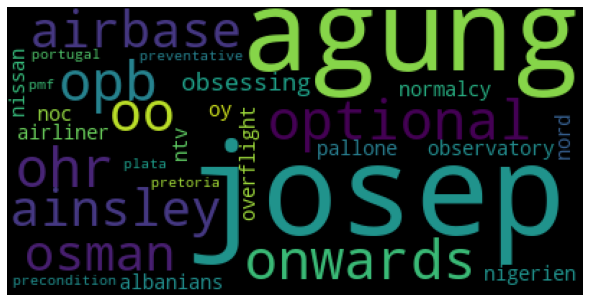

Topic 1:
homs distinguish ard nutty nutshell nutjob disturb archer disturbances nussbaum arcane diverge distasteful divergence divestment nuke dividend nugent thereof divulged thew thi dixon nuance djt null thom objectively obsessive
word cloud



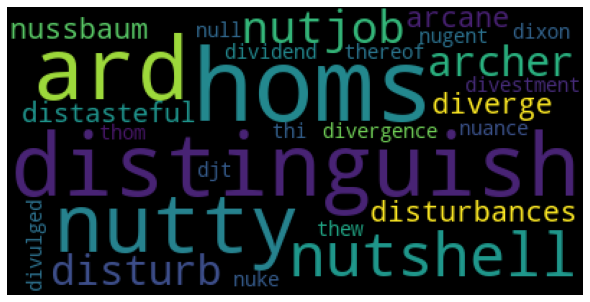

Topic 2:
offerings fragmentation francophone rowling justifiable juries frat torches frauke freaks frederica frontiers funksoul juice ruger judeo juanita tilting g5 rwandan byrd sabo jindal amt trafficked gabe rowan fpl annihilation
word cloud



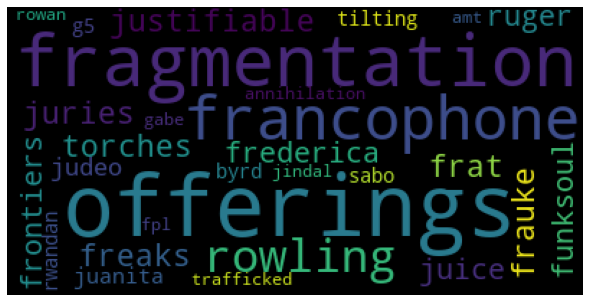

Topic 3:
lighthizer keiko rubles barfly barclays ruinous rumbling baluchistan khaqan ryabkov saffir balbi katrin salame karimov bahram sandberg baltics cicig romatet absentia bassil amman liberalization allgemeine levies abdullahi chlorine leandra
word cloud



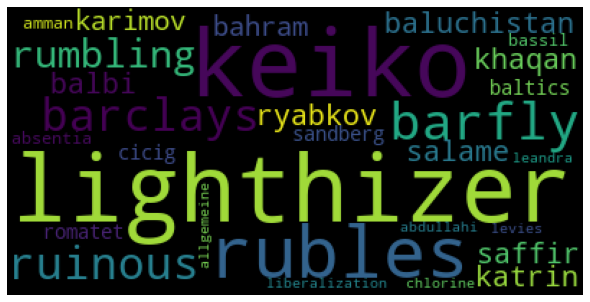

Topic 4:
josep appalachian appalachia handel hanks hanson harlem harriet hart apiece vowg apparel hathaway hb2 anwr heckler hecklers hectares semiconductors heeled semiautomatic heitkamp henrique hauck sekulow hampton hamburger shaved grove
word cloud



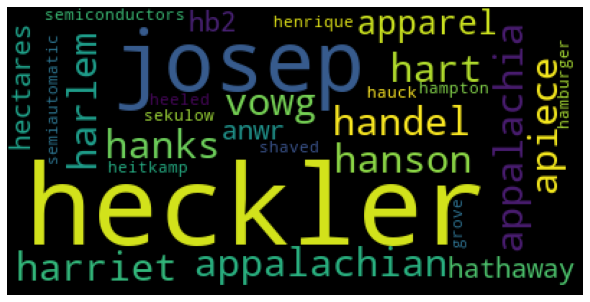

Topic 5:
levying opb ordinances oriol gebran galizia g5 overcapacity overran overstayed overstepping oo overstretched ozdemir panamanian fukushima paraguay paralyze fujimori parliaments partition pashtun payout ovp onwards ghassan oilfields ndaa nepal
word cloud



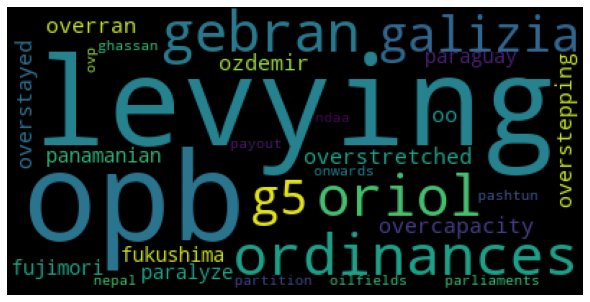

Topic 6:
josep amtrak amt paso cough participates parishioners parish parcels paramilitaries thew paraguay panned ammosexual ammo panelists panelist covfefe pals palmyra cps cracker crackers pakistanis costume passages passersby cosby perez
word cloud



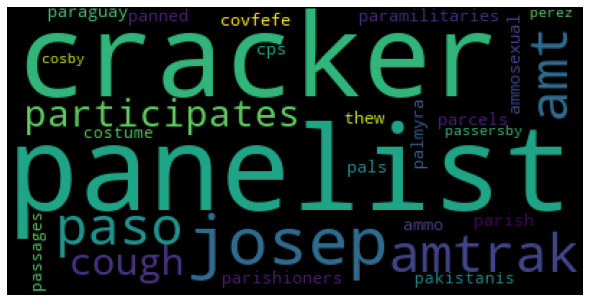

Topic 7:
nonproliferation refiners constructively implements implode impotent inbound auckland incumbents brumskine recriminations recommends impeaching recognise recertify abdulaziz rebuff inefficiency rebekah rebate conquest connaughton reauthorization reasserted realistically incursions brotherly ileana refueling
word cloud



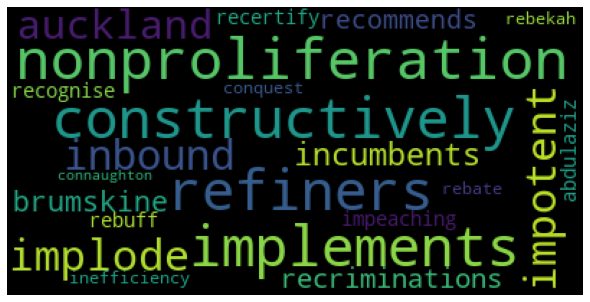

Topic 8:
zurich hindus abul hijab hideout hempstead heinz hectares hebrew hb hawija hauck hasina hardships haq hapilon hanks handouts han hama halftime haidar habur haber gwadar guttmacher guitar guillier hiroshima
word cloud



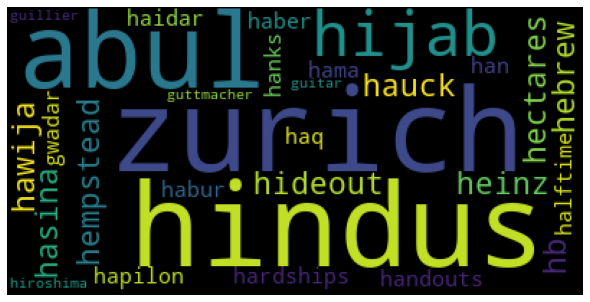

Topic 9:
mora replenish cfpb filibusters milliken thy res hempstead tidal cfius vandals alumni drake succumb vanilla respiratory filers meth chapman henderson tulsa mirage reorganize heartbroken reiner downstairs downstream sunglasses throughs
word cloud



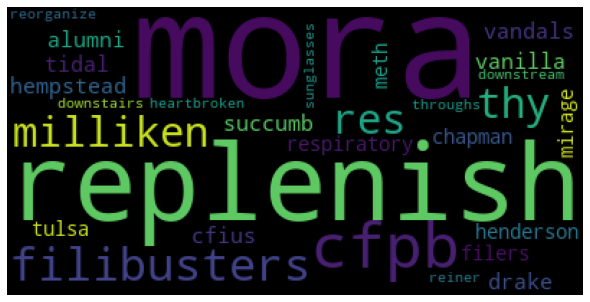

Topic 10:
hash populists pony turki pollutants covfefe cowboy cowboys cpp cracker crackers polar poking crater turnouts crawled tweeter plutonium plumbing credibly porch possesses tunes alaskan predictit alexei coping tu alerting
word cloud



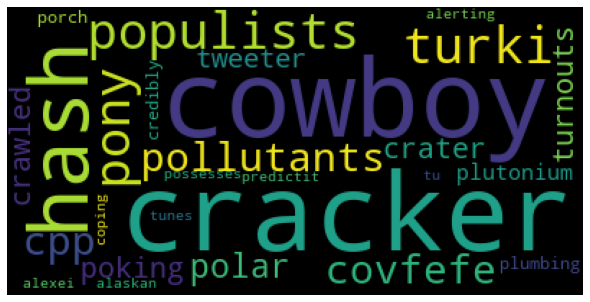

Topic 11:
mourners terrorizing terrorized cst crybaby nuns crosstalk fayez wed ambushed croats cremation ammar weissmann credibly homily tehreek feigned fein ole orc osce ostracized cosby ntv cube howe watters extramarital
word cloud



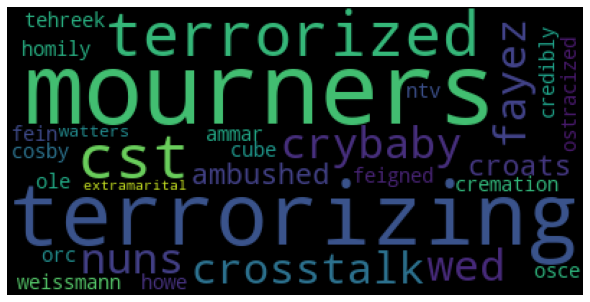

Topic 12:
josep kanye kamerun kamala bennett kalanick bentley benz kaiser berating kaczynski berkon juvenile berlusconi juries bern junts junqueras bershad jumpsuit jules bespoke kaplan bengal karachi kardashian kirkpatrick belittle kingmaker
word cloud



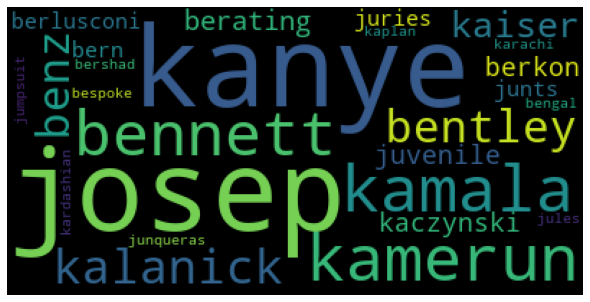

Topic 13:
invalidate roasted contreras affordability rika unpatriotic conundrum convenes riders unpopularity riddance ricky unpresidented unpresidential ricketts cookie ribs cooperatives rfs reynolds roasting reykjavik robotic robots unitedhealth congratulating connaughton ruffle conner
word cloud



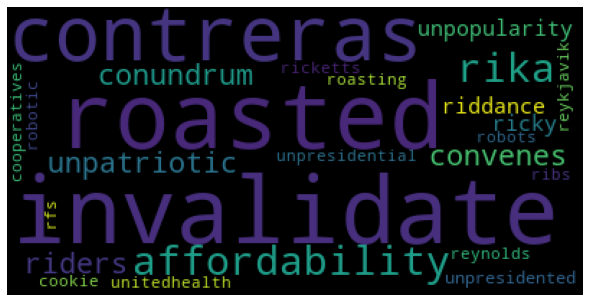

Topic 14:
josep fuhrer frontiers freeway frauke frans francophone fpl foresees fukushima foreseen forcadell forbidding flourished flour floodwaters flocking flats firstly forecasters fulfil funksoul g5 greasy graph grandpa grandi gothenburg goon
word cloud



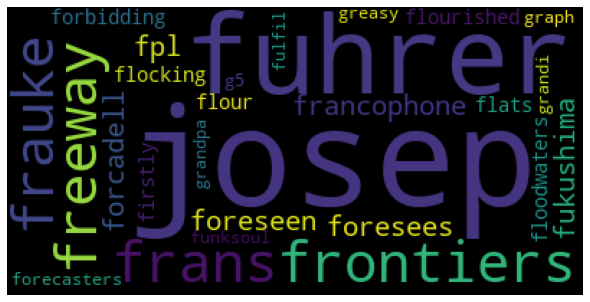

Topic 15:
estonia sandwich sandoval menacing mendez impeccable ukip konashenkov impediment sanctioning impenetrable connaughton salmon connects conner gallon gallagher anathema salafist gainesville gaggle sailed gaffe saffir sandwiches saenz santamaria ugliness gebran
word cloud



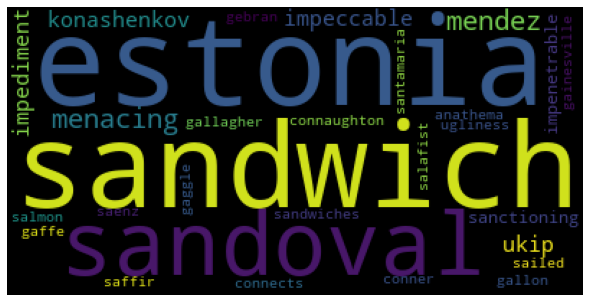

Topic 16:
wittingly rcep guillain deductibility guillier undercutting readout reaffirming deducting deceiving strzok nlrb reasserted reassess hakan cutoff hamm habur spurned defunding gryphon ohr oge qataris barrasso quarles designations 2017seriously ratcliffe
word cloud



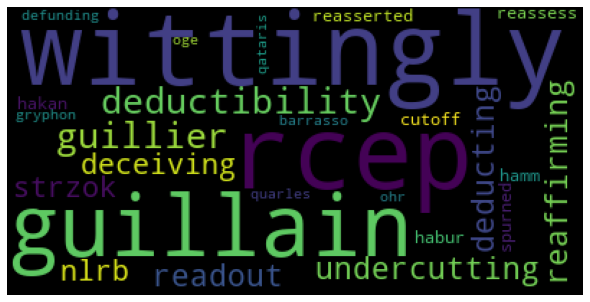

Topic 17:
rocker fethullah fidesz fiji finals obsessive stewards stereotyping adorable adoration flagpole adulyadej centcom flailing oic stampede flats floodwaters staffan centres srebrenica spurious spreaker biya kompromat spouting konashenkov koreas coping
word cloud



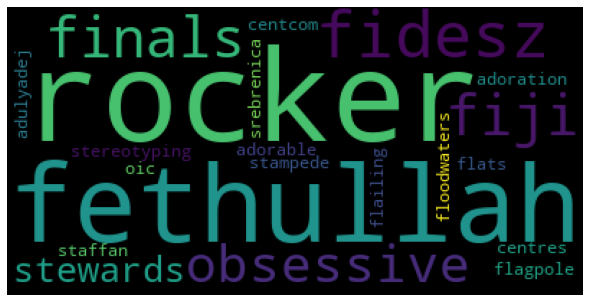

Topic 18:
anticipates refiners bpd durable dujarric kobach duckworth komeito recertify aftershocks 2023 druze branstad reauthorization downstream downgrades kyung reassess breakout dubke rcep eleventh affordability 310 expensing expeditiously junqueras ayrault boochani
word cloud



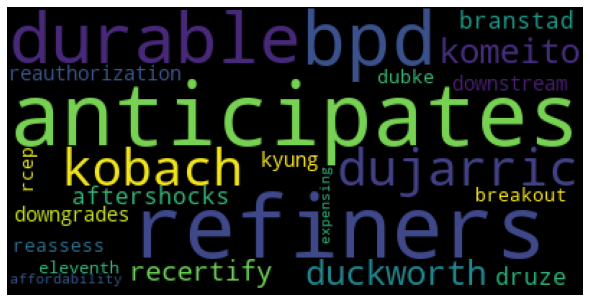

Topic 19:
hilarity kompromat dotard tubman stumping freaks afar afari nahayan rte depreciation picnic kristol downed vassily mayadin balbi balconies cm wittingly inflatable varadkar tufts wl nasrallah bff tolerates bohuslav frederica
word cloud



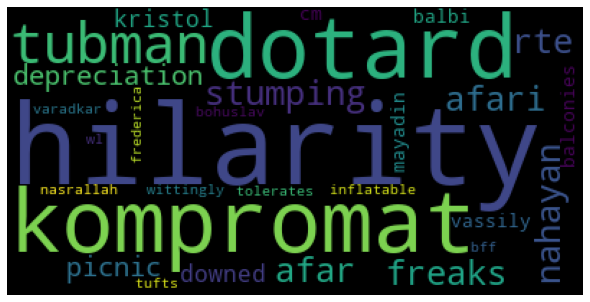

In [69]:
no_top_words=30#taking top 30 words in each topic
display_topics(lda_model, vec.get_feature_names(), no_top_words)

## 8. Merging Categorical, Text, Title Features and one hot encoding of number of topics

### 8.1 BOW

In [70]:
from scipy.sparse import hstack
x_train_bow = hstack((x_train_subject,x_train_date,x_train_text_bow,x_train_title_bow,train_encoding)).tocsr()
print(x_train_bow.shape)

x_cv_bow = hstack((x_cv_subject,x_cv_date,x_cv_text_bow,x_cv_title_bow,cv_encoding)).tocsr()
print(x_cv_bow.shape)

x_test_bow = hstack((x_test_subject,x_test_date,x_test_text_bow,x_test_title_bow,test_encoding)).tocsr()
print(x_test_bow.shape)
print("="*100)

(24726, 26196)
(6182, 26196)
(7728, 26196)


### 8.2 TFIDF

In [71]:
x_train_tfidf = hstack((x_train_subject,x_train_date,x_train_text_tfidf,x_train_title_tfidf,train_encoding)).tocsr()
print(x_train_tfidf.shape)

x_cv_tfidf = hstack((x_cv_subject,x_cv_date,x_cv_text_tfidf,x_cv_title_tfidf,cv_encoding)).tocsr()
print(x_cv_tfidf.shape)

x_test_tfidf = hstack((x_test_subject,x_test_date,x_test_text_tfidf,x_test_title_tfidf,test_encoding)).tocsr()
print(x_test_tfidf.shape)
print("="*100)

(24726, 26196)
(6182, 26196)
(7728, 26196)


# 9. Applying Models

## 9.1 Applying MultinomialNB

### 9.1.1 BOW

100%|██████████| 15/15 [00:00<00:00, 16.07it/s]


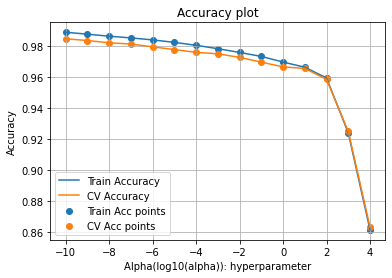

In [72]:
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score


train_accuracy = []
cv_accuracy = []
alp=[10**i for i in range(-10,5)]
for i in tqdm(alp):
    nb =MultinomialNB(alpha=i)
    nb.fit(x_train_bow, y_train)

    y_train_pred = nb.predict(x_train_bow)    
    y_cv_pred = nb.predict(x_cv_bow)
    
       
    train_accuracy.append(accuracy_score(y_train,y_train_pred))
    cv_accuracy.append(accuracy_score(y_cv, y_cv_pred))
    
    

alp_log=np.log10(alp)

plt.plot(alp_log, train_accuracy, label='Train Accuracy')
plt.plot(alp_log, cv_accuracy, label='CV Accuracy')

plt.scatter(alp_log, train_accuracy, label='Train Acc points')
plt.scatter(alp_log, cv_accuracy, label='CV Acc points')

plt.legend()
plt.xlabel("Alpha(log10(alpha)): hyperparameter")
plt.ylabel("Accuracy")
plt.title("Accuracy plot")
plt.grid()
plt.show()

In [73]:
best_alpha=1e-10

nb = MultinomialNB(alpha=best_alpha)
nb.fit(x_train_bow, y_train)

y_test_pred=nb.predict(x_test_bow)
accuracy=accuracy_score(y_test,y_test_pred)*100

print("accuracy on test data:",accuracy)

accuracy on test data: 98.35662525879917


### 9.1.2 TFIDF

100%|██████████| 18/18 [00:01<00:00, 16.44it/s]


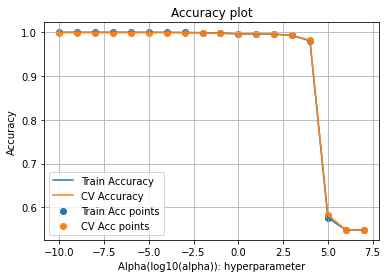

In [74]:
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score


train_accuracy = []
cv_accuracy = []
alp=[10**i for i in range(-10,8)]
for i in tqdm(alp):
    nb =MultinomialNB(alpha=i)
    nb.fit(x_train_tfidf, y_train)

    y_train_pred = nb.predict(x_train_tfidf)    
    y_cv_pred = nb.predict(x_cv_tfidf)
    
       
    train_accuracy.append(accuracy_score(y_train,y_train_pred))
    cv_accuracy.append(accuracy_score(y_cv, y_cv_pred))
    
    

alp_log=np.log10(alp)

plt.plot(alp_log, train_accuracy, label='Train Accuracy')
plt.plot(alp_log, cv_accuracy, label='CV Accuracy')

plt.scatter(alp_log, train_accuracy, label='Train Acc points')
plt.scatter(alp_log, cv_accuracy, label='CV Acc points')

plt.legend()
plt.xlabel("Alpha(log10(alpha)): hyperparameter")
plt.ylabel("Accuracy")
plt.title("Accuracy plot")
plt.grid()
plt.show()

In [75]:
best_alpha=1e-10

nb = MultinomialNB(alpha=best_alpha)
nb.fit(x_train_tfidf, y_train)

y_test_pred=nb.predict(x_test_tfidf)
accuracy=accuracy_score(y_test,y_test_pred)*100

print("accuracy on test data:",accuracy)

accuracy on test data: 99.87060041407867


## 9.2 Applying Logistic Regression

### 9.2.1 BOW

100%|██████████| 15/15 [00:04<00:00,  3.35it/s]


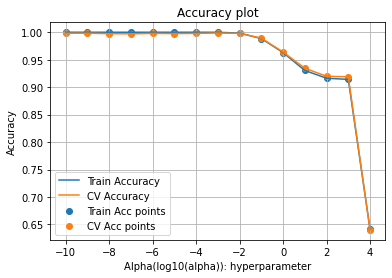

In [76]:
from sklearn.linear_model import SGDClassifier
train_accuracy=[]
cv_accuracy=[]

alp=[10**i for i in range(-10,5)]
for i in tqdm(alp):
    lr=SGDClassifier(loss='log',n_jobs=-1,alpha=i,class_weight='balanced')
    lr.fit(x_train_bow,y_train)
    
    y_train_pred=lr.predict(x_train_bow)
    y_cv_pred=lr.predict(x_cv_bow)
    
    train_accuracy.append(accuracy_score(y_train,y_train_pred))
    cv_accuracy.append(accuracy_score(y_cv,y_cv_pred))

    
alp_log=np.log10(alp)

plt.plot(alp_log, train_accuracy, label='Train Accuracy')
plt.plot(alp_log, cv_accuracy, label='CV Accuracy')

plt.scatter(alp_log, train_accuracy, label='Train Acc points')
plt.scatter(alp_log, cv_accuracy, label='CV Acc points')

plt.legend()
plt.xlabel("Alpha(log10(alpha)): hyperparameter")
plt.ylabel("Accuracy")
plt.title("Accuracy plot")
plt.grid()
plt.show()

In [77]:
best_alpha=10**-10
lr=SGDClassifier(loss='log',alpha=best_alpha,n_jobs=-1,class_weight='balanced')
lr.fit(x_train_bow,y_train)

y_test_pred=lr.predict(x_test_bow)
accuracy=accuracy_score(y_test,y_test_pred)*100

print("accuracy on test data:",accuracy)

accuracy on test data: 99.70238095238095


### 9.2.2 TFIDF

100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


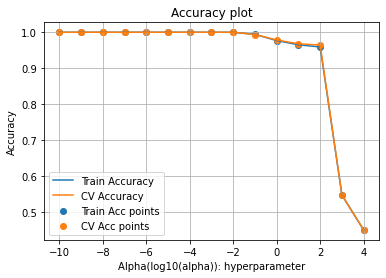

In [78]:
from sklearn.linear_model import SGDClassifier
train_accuracy=[]
cv_accuracy=[]

alp=[10**i for i in range(-10,5)]
for i in tqdm(alp):
    lr=SGDClassifier(loss='log',n_jobs=-1,alpha=i,class_weight='balanced')
    lr.fit(x_train_tfidf,y_train)
    
    y_train_pred=lr.predict(x_train_tfidf)
    y_cv_pred=lr.predict(x_cv_tfidf)
    
    train_accuracy.append(accuracy_score(y_train,y_train_pred))
    cv_accuracy.append(accuracy_score(y_cv,y_cv_pred))

    
alp_log=np.log10(alp)

plt.plot(alp_log, train_accuracy, label='Train Accuracy')
plt.plot(alp_log, cv_accuracy, label='CV Accuracy')

plt.scatter(alp_log, train_accuracy, label='Train Acc points')
plt.scatter(alp_log, cv_accuracy, label='CV Acc points')

plt.legend()
plt.xlabel("Alpha(log10(alpha)): hyperparameter")
plt.ylabel("Accuracy")
plt.title("Accuracy plot")
plt.grid()
plt.show()

In [79]:
best_alpha=10**-9
lr=SGDClassifier(loss='log',alpha=best_alpha,n_jobs=-1,class_weight='balanced')
lr.fit(x_train_tfidf,y_train)

y_test_pred=lr.predict(x_test_tfidf)
accuracy=accuracy_score(y_test,y_test_pred)*100

print("accuracy on test data:",accuracy)

accuracy on test data: 100.0


## 9.3 Applying SVM

### 9.3.1 BOW

100%|██████████| 15/15 [00:03<00:00,  4.38it/s]


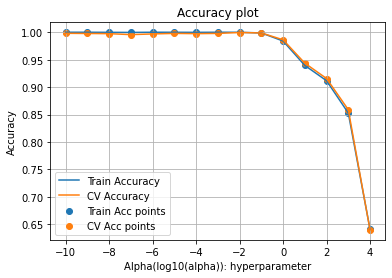

In [80]:
from sklearn.linear_model import SGDClassifier

train_accuracy=[]
cv_accuracy=[]
alp=[10**i for i in range(-10,5)]
for i in tqdm(alp):
    sgd=SGDClassifier(loss='hinge',alpha=i,n_jobs=-1,class_weight='balanced')
    sgd.fit(x_train_bow,y_train)
    
    y_train_pred=sgd.predict(x_train_bow)
    y_cv_pred=sgd.predict(x_cv_bow)
    
    train_accuracy.append(accuracy_score(y_train,y_train_pred))
    cv_accuracy.append(accuracy_score(y_cv,y_cv_pred))

alp_log=np.log10(alp)

plt.plot(alp_log, train_accuracy, label='Train Accuracy')
plt.plot(alp_log, cv_accuracy, label='CV Accuracy')

plt.scatter(alp_log, train_accuracy, label='Train Acc points')
plt.scatter(alp_log, cv_accuracy, label='CV Acc points')

plt.legend()
plt.xlabel("Alpha(log10(alpha)): hyperparameter")
plt.ylabel("Accuracy")
plt.title("Accuracy plot")
plt.grid()
plt.show()

In [81]:
best_alpha=1e-10

sg=SGDClassifier(loss='hinge',alpha=best_alpha,n_jobs=-1,class_weight='balanced')
sg.fit(x_train_bow,y_train)

y_test_pred=sg.predict(x_test_bow)
accuracy=accuracy_score(y_test,y_test_pred)*100

print("accuracy on test data:",accuracy)

accuracy on test data: 99.37888198757764


### 9.3.2 TFIDF

100%|██████████| 11/11 [00:01<00:00,  5.90it/s]


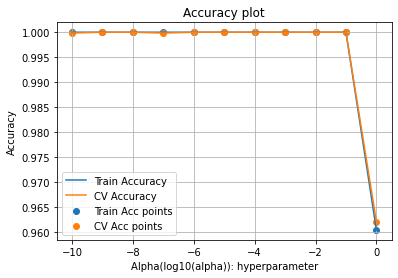

In [82]:
from sklearn.linear_model import SGDClassifier

train_accuracy=[]
cv_accuracy=[]
alp=[10**i for i in range(-10,1)]
for i in tqdm(alp):
    sgd=SGDClassifier(loss='hinge',alpha=i,n_jobs=-1,class_weight='balanced')
    sgd.fit(x_train_tfidf,y_train)
    
    y_train_pred=sgd.predict(x_train_tfidf)
    y_cv_pred=sgd.predict(x_cv_tfidf)
    
    train_accuracy.append(accuracy_score(y_train,y_train_pred))
    cv_accuracy.append(accuracy_score(y_cv,y_cv_pred))

alp_log=np.log10(alp)

plt.plot(alp_log, train_accuracy, label='Train Accuracy')
plt.plot(alp_log, cv_accuracy, label='CV Accuracy')

plt.scatter(alp_log, train_accuracy, label='Train Acc points')
plt.scatter(alp_log, cv_accuracy, label='CV Acc points')

plt.legend()
plt.xlabel("Alpha(log10(alpha)): hyperparameter")
plt.ylabel("Accuracy")
plt.title("Accuracy plot")
plt.grid()
plt.show()

In [83]:
best_alpha=1e-9

sgd_model=SGDClassifier(loss='hinge',alpha=best_alpha,n_jobs=-1,class_weight='balanced')
sgd_model.fit(x_train_tfidf,y_train)

y_test_pred=sgd_model.predict(x_test_tfidf)
accuracy=accuracy_score(y_test,y_test_pred)*100

print("accuracy on test data:",accuracy)

accuracy on test data: 100.0


# 10. Applying LSTM

In [0]:
text = Tokenizer()
text.fit_on_texts(x_train['text'])
x_train_encoded=text.texts_to_sequences(x_train['text'])
x_cv_encoded=text.texts_to_sequences(x_cv['text'])
x_test_encoded=text.texts_to_sequences(x_test['text'])

x_train_padded=pad_sequences(x_train_encoded,maxlen=500)
x_cv_padded=pad_sequences(x_cv_encoded,maxlen=500)
x_test_padded=pad_sequences(x_test_encoded,maxlen=500)

vocab_size_text = len(text.word_index) + 1

In [0]:
with open("lstm_text_weight.pickle","wb") as f:
    pickle.dump(text, f)

In [0]:
title = Tokenizer()
title.fit_on_texts(x_train['title'])
x_train_encoded_title=title.texts_to_sequences(x_train['title'])
x_cv_encoded_title=title.texts_to_sequences(x_cv['title'])
x_test_encoded_title=title.texts_to_sequences(x_test['title'])

x_train_padded_title=pad_sequences(x_train_encoded_title,maxlen=100)
x_cv_padded_title=pad_sequences(x_cv_encoded_title,maxlen=100)
x_test_padded_title=pad_sequences(x_test_encoded_title,maxlen=100)

vocab_size_title = len(title.word_index) + 1

In [0]:
with open("lstm_title_weight.pickle", "wb") as f:
    pickle.dump(title, f)

In [0]:
np.random.seed(42)
tf.random.set_seed(32) 
rn.seed(12) 

def get_lstm_model():
    
    #text input
    text_in = Input(shape=(x_train_padded.shape[1],))
    text_layer = Embedding(input_dim=vocab_size_text, output_dim=64, trainable = True, mask_zero = True)(text_in)
    text_layer = LSTM(64, activation="tanh", recurrent_activation="sigmoid", use_bias=True, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=45),
                      recurrent_initializer=tf.keras.initializers.orthogonal(seed=54), bias_initializer="zeros")(text_layer)

    text_layer = Flatten()(text_layer)


    #title input
    title_in = Input(shape=(x_train_padded_title.shape[1],))
    title_layer = Embedding(input_dim=vocab_size_title, output_dim=64, trainable = True, mask_zero = True)(title_in)
    title_layer = LSTM(64, activation="tanh", recurrent_activation="sigmoid", use_bias=True, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=45),
                       recurrent_initializer=tf.keras.initializers.orthogonal(seed=54), bias_initializer="zeros")(title_layer)

    title_layer = Flatten()(title_layer)


    #subject input
    subject = Input(shape=(x_train_subject .shape[1],))
    subject_layer = Embedding(input_dim=x_train_date.shape[1],output_dim=64, mask_zero = True)(subject)
    subject_layer = Flatten()(subject_layer)

    #date input
    date = Input(shape=(x_train_date.shape[1],))
    date_layer = Embedding(input_dim=x_train_date.shape[1],output_dim=64, mask_zero = True)(date)
    date_layer = Flatten()(date_layer)
    
    #concatenating
    concat = concatenate(inputs=[text_layer, title_layer, subject_layer, date_layer])


    #output
    output = Dense(64, activation='relu')(concat)
    output = BatchNormalization()(output)
    output = Dropout(0.25)(output)
    output = Dense(32,activation = 'relu')(output)
    output = Dropout(0.5)(output)
    output = Dense(2 ,activation='softmax')(output)

    model = Model(inputs=[text_in, title_in, subject, date], outputs = output)
    
    return model

In [91]:
model = get_lstm_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 500, 64)      5737600     input_3[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 100, 64)      1134848     input_4[0][0]                    
______________________________________________________________________________________________

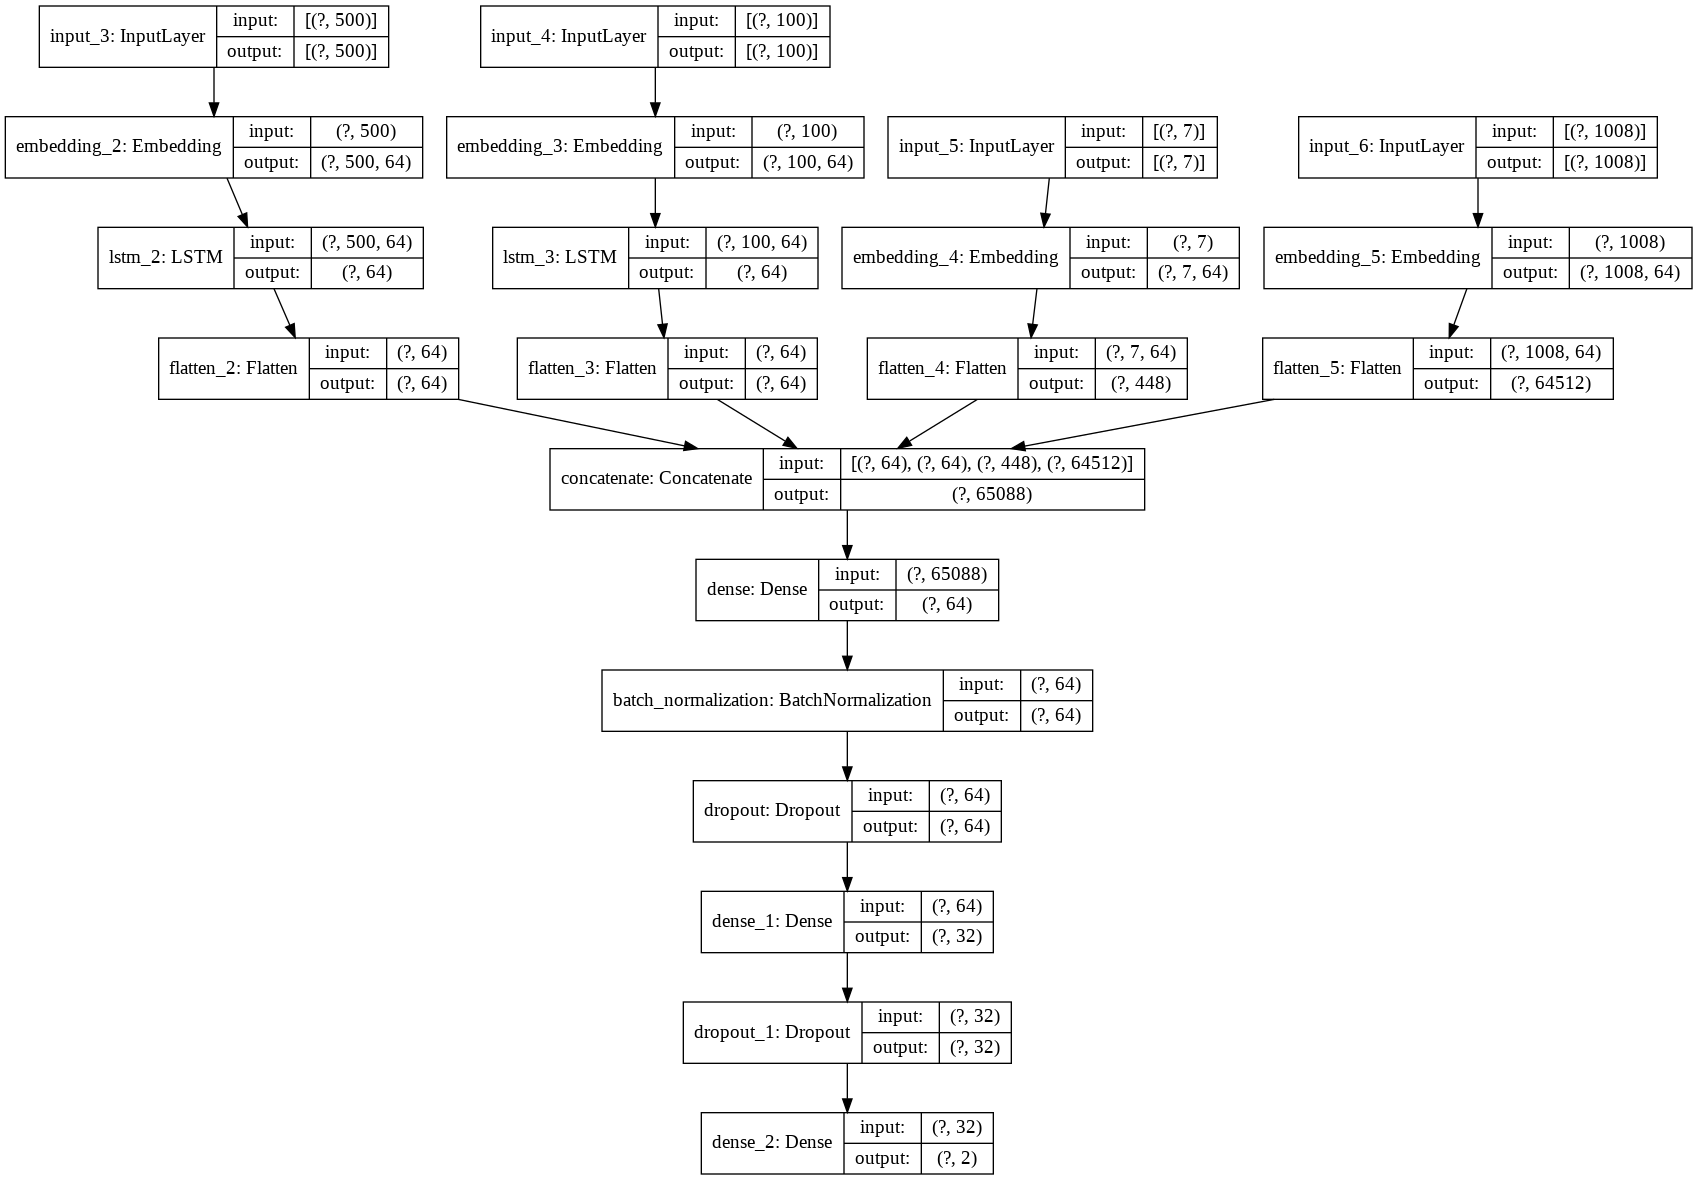

In [92]:
plot_model(model, to_file='lstm_model_plot.png', show_shapes=True, show_layer_names=True)

In [93]:
from keras.utils import np_utils
y_tr = np_utils.to_categorical(y_train)
y_c = np_utils.to_categorical(y_cv)
y_te = np_utils.to_categorical(y_test)

Using TensorFlow backend.


In [95]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit([x_train_padded, x_train_padded_title, x_train_subject, x_train_date], y_tr, epochs=5, batch_size=1000, validation_data = ([x_cv_padded, x_cv_padded_title, x_cv_subject, x_cv_date],y_c))

Epoch 1/5
25/25 [==============================] - 159s 6s/step - loss: 0.0050 - accuracy: 1.0000 - val_loss: 3.1157 - val_accuracy: 0.5484
Epoch 2/5
25/25 [==============================] - 158s 6s/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.5435 - val_accuracy: 0.5492
Epoch 3/5
25/25 [==============================] - 161s 6s/step - loss: 7.8661e-04 - accuracy: 1.0000 - val_loss: 0.0887 - val_accuracy: 1.0000
Epoch 4/5
25/25 [==============================] - 159s 6s/step - loss: 5.6297e-04 - accuracy: 1.0000 - val_loss: 0.0141 - val_accuracy: 1.0000
Epoch 5/5
25/25 [==============================] - 158s 6s/step - loss: 4.0334e-04 - accuracy: 1.0000 - val_loss: 0.0048 - val_accuracy: 1.0000


In [96]:
y_pred = model.evaluate([x_test_padded, x_test_padded_title, x_test_subject, x_test_date], y_te)

242/242 [==============================] - 23s 94ms/step - loss: 0.0048 - accuracy: 1.0000


# 11. Accuracy of all the model on my train data

In [97]:
from prettytable import PrettyTable

x = PrettyTable()


x.field_names = ["Model", "VECTORIZING TEXT AND TITLE", "HYPER PARAMETER", "ACCURACY"]

x.add_row(["NAIVE BAYES", "BOW", 1e-10, 98.35])
x.add_row(["NAIVE BAYES", "TFIDF", 1e-10, 99.87])

x.add_row(["LOGISTIC REGRESSION", "BOW", 1e-10, 99.70])
x.add_row(["LOGISTIC REGRESSION", "TFIDF", 1e-9, 100])

x.add_row(["SVM", "BOW", 1e-10, 99.37])
x.add_row(["SVM", "TFIDF", 1e-9, 100])


print(x)

+---------------------+----------------------------+-----------------+----------+
|        Model        | VECTORIZING TEXT AND TITLE | HYPER PARAMETER | ACCURACY |
+---------------------+----------------------------+-----------------+----------+
|     NAIVE BAYES     |            BOW             |      1e-10      |  98.35   |
|     NAIVE BAYES     |           TFIDF            |      1e-10      |  99.87   |
| LOGISTIC REGRESSION |            BOW             |      1e-10      |   99.7   |
| LOGISTIC REGRESSION |           TFIDF            |      1e-09      |   100    |
|         SVM         |            BOW             |      1e-10      |  99.37   |
|         SVM         |           TFIDF            |      1e-09      |   100    |
+---------------------+----------------------------+-----------------+----------+


In [98]:
from prettytable import PrettyTable

x = PrettyTable()

x.field_names = ["Model", "Epochs", "Accuracy"]
x.add_row(["LSTM", 10, 100])

print(x)

+-------+--------+----------+
| Model | Epochs | Accuracy |
+-------+--------+----------+
|  LSTM |   10   |   100    |
+-------+--------+----------+


### Summary

__SVM gives 100% accuracy on test data when we used tfidf vectorizer for text data.__

__LSTM also give 100% accuracy on test data.__

In [0]:
model.save("lstm_model.h5")#saving lstm model

In [0]:
#saving svm model
with open("svm_model.pickle", "wb") as f:
    pickle.dump(sgd_model,f)